# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [24]:
!pip install tensorflow-datasets
!pip install ipywidgets
!pip install matplotlib
!pip install plotly


In [116]:
# TODO: Make all necessary imports.
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import numpy as np
from tensorflow.keras import layers, models

import json
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [117]:
# TODO: Load the dataset with TensorFlow Datasets.
import tensorflow_datasets as tfds
splits = ['train', 'validation', 'test']
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True, split=splits)

# TODO: Create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset
dataset
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Explore the Dataset

In [118]:
# TODO: Get the number of examples in each set from the dataset info.
num_train_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

# TODO: Get the number of classes in the dataset from the dataset info
num_classes = dataset_info.features['label'].num_classes

num_classes
print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_validation_examples}")
print(f"Number of test examples: {num_test_examples}")
print(f"Number of classes: {num_classes}")



Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149
Number of classes: 102


In [119]:
# TODO: Print the shape and corresponding label of 3 images in the training set.

for i, (image, label) in enumerate(training_set.take(3)):  
    print(f"Image {i + 1}:")
    print(f"Shape: {image.shape}")
    print(f"Label: {label}")
    print("-" * 30)

Image 1:
Shape: (500, 667, 3)
Label: 72
------------------------------
Image 2:
Shape: (500, 666, 3)
Label: 84
------------------------------
Image 3:
Shape: (670, 500, 3)
Label: 70
------------------------------


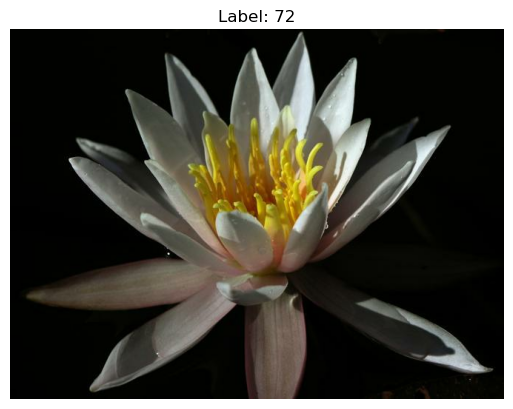

In [120]:
# TODO: Plot 1 image from the training set. Set the title 
for image, label in training_set.take(1): 
    plt.imshow(image)  
    plt.title(f"Label: {label.numpy()}")  
    plt.axis('off')  
    plt.show()  


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [121]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

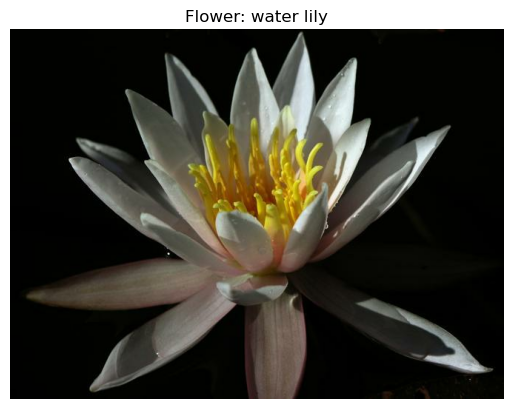

In [122]:
for image, label in training_set.take(1): 
    flower_name = class_names[str(label.numpy())]  
    
    plt.imshow(image)  
    plt.title(f"Flower: {flower_name}")  
    plt.axis('off')  
    plt.show()  



## Create Pipeline

In [123]:
def normalize_and_resize(image, label, target_size=(224, 224)):
    image = tf.cast(image, tf.float32) 
    image = tf.image.resize(image, target_size)

    image /= 255.0
    
    return image, label

batch_size = 64

training_batches = (training_set
                    .cache()
                    .shuffle(1000)
                    .map(lambda x, y: normalize_and_resize(x, y))  
                    .batch(batch_size)
                    .prefetch(1))

validation_batches = (validation_set
                     .cache()
                     .map(lambda x, y: normalize_and_resize(x, y))  
                     .batch(batch_size)
                     .prefetch(1))

testing_batches = (test_set
                   .cache()
                   .map(lambda x, y: normalize_and_resize(x, y))  
                   .batch(batch_size)
                   .prefetch(1))

for images, labels in training_batches.take(1):
    print(images.shape)  

(64, 224, 224, 3)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [124]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(
    training_batches,
    epochs=5,
    validation_data=validation_batches
)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_15 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 1024)                │     154,141,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,671,626 (590.03 MB)

 Trainable params: 154,671,626 (590.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\runpy.py", line 198, in _run_module_as_main

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\runpy.py", line 88, in _run_code

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\omar.DESKTOP-4KRKGQT\AppData\Local\Temp\ipykernel_2264\2428424676.py", line 16, in <module>

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 368, in fit

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 216, in function

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 129, in multi_step_on_iterator

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 59, in train_step

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 399, in _compute_loss

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 367, in compute_loss

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 692, in __call__

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 701, in call

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\losses\losses.py", line 2241, in sparse_categorical_crossentropy

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\ops\nn.py", line 1841, in sparse_categorical_crossentropy

  File "C:\Users\omar.DESKTOP-4KRKGQT\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 714, in sparse_categorical_crossentropy

Received a label value of 101 which is outside the valid range of [0, 10).  Label values: 30 36 39 41 20 6 33 11 98 43 71 98 74 10 28 67 49 22 80 29 41 33 64 40 35 96 41 2 42 52 66 52 48 40 72 25 36 58 78 69 61 101 15 10 26 46 59 9 59 45 12 73 54 23 1 1 19 63 44 52 100 99 72 70
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_42723]

NameError: name 'history' is not defined

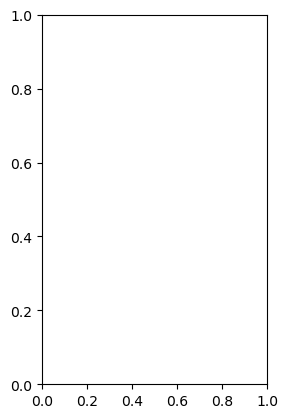

In [125]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = my_model.evaluate(testing_batches)

print(f'\nLoss on the TEST Set: {loss:,.3f}')
print(f'Accuracy on the TEST Set: {accuracy:.3%}')



## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [127]:
# TODO: Save your trained model as a Keras model.
import time
t = time.time()
saved_keras_model_filepath = f'./{int(t)}.keras'

model.save(saved_keras_model_filepath)



ValueError: I/O operation on closed file.

## Load the Keras Model

Load the Keras model you saved above.

In [128]:
# TODO: Load the Keras model
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath)

np.testing.assert_allclose(
    model.predict(testing_batches), reloaded_keras_model.predict(testing_batches)
)

print(f"Model successfully saved and loaded in .keras format from {saved_keras_model_filepath}")




ValueError: Expected a model.weights.h5 or model.weights.npz file.

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [129]:
def process_image(image):
    if isinstance(image, np.ndarray):
        img = image
    else:
        img = np.asarray(Image.open(image))
    
    img = Image.fromarray(img).resize((224, 224))
    img = np.array(img)

    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)

    img = img.astype(np.float32) / 255.0
    
    img = tf.convert_to_tensor(img)
    
    img = tf.expand_dims(img, axis=0)
    
    return img


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

TypeError: Invalid shape (1, 224, 224, 3) for image data

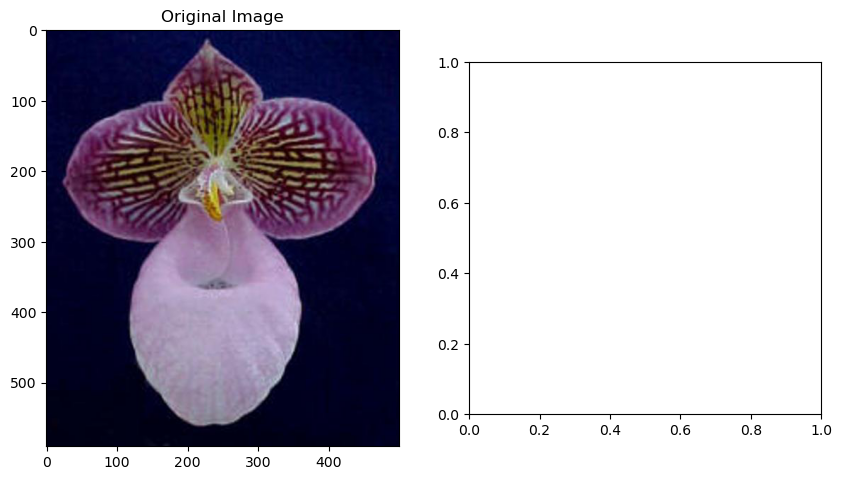

In [130]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [131]:
def predict(image_path, model, top_k=5):
    image = Image.open(image_path)
    processed_image = process_image(np.asarray(image))
    preds = model.predict(processed_image)
    top_k_probs = tf.nn.softmax(preds[0]).numpy()
    top_k_indices = np.argsort(top_k_probs)[-top_k:][::-1]
    class_names = [str(i) for i in top_k_indices]
    top_k_probs = top_k_probs[top_k_indices]
    
    return top_k_probs, class_names

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
top_k = 5

probs, classes = predict(image_path, model, top_k)

print("Probabilities:", probs)
print("Classes:", classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
Probabilities: [0.10003638 0.10001928 0.10000874 0.10000663 0.10000056]
Classes: ['4', '7', '0', '8', '3']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


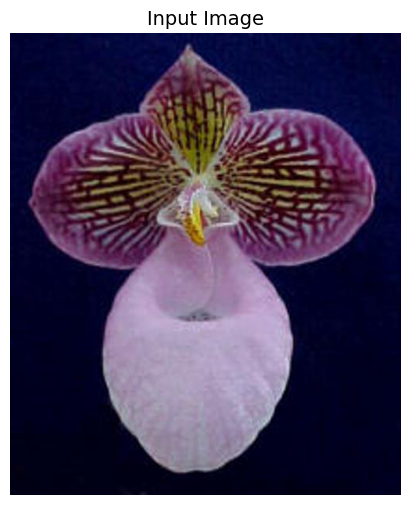

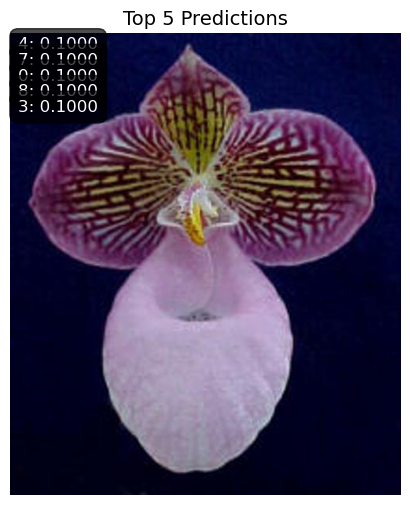

In [132]:
def plot_top_classes(image_path, model, top_k=5):
    probs, classes = predict(image_path, model, top_k)
    image = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image', fontsize=14)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Top {top_k} Predictions", fontsize=14)
    
    for i in range(top_k):
        plt.text(10, 20 + i*20, f"{classes[i]}: {probs[i]:.4f}", color='white', fontsize=12, 
                 bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.5'))

    plt.show()

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
top_k = 5

plot_top_classes(image_path, model, top_k)